In [1]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx)) 
b = numpy.zeros((ny, nx))

> The pressure Poisson equation that's written above can be hard to write out without typos. The function `build_up_b` below represents the contents of the square brackets, so that the entirety of the PPE is slightly more manageable.

上面写的压力泊松方程可能很难写出来，没有错别字。下面的函数`build_up_b`表示方括号内的内容，这样整个压力泊松方程就稍微好处理了。

In [3]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

> The function `pressure_poisson` is also defined to help segregate the different rounds of calculations. Note the presence of the pseudo-time variable `nit`. This sub-iteration in the Poisson calculation helps ensure a divergence-free field.

还定义了函数`pressure_poisson`以帮助隔离不同的计算轮次。注意伪时间变量 `nit` 的存在。泊松计算中的这个子迭代有助于确保一个无发散的领域。

In [4]:
def pressure_poisson(p, dx, dy, b):
    pn = numpy.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

> Finally, the rest of the cavity flow equations are wrapped inside the function `cavity_flow`, allowing us to easily plot the results of the cavity flow solver for different lengths of time.

最后，其余的空腔流方程被包裹在函数`cavity_flow`中，使我们能够轻松地绘制出不同时间长度的空腔流求解结果。

In [5]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
    return u, v, p

> Let's start with `nt = 100` and see what the solver gives us:

让我们从 `nt = 100` 开始，看看求解器给我们的结果。

In [6]:
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))
nt = 100
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

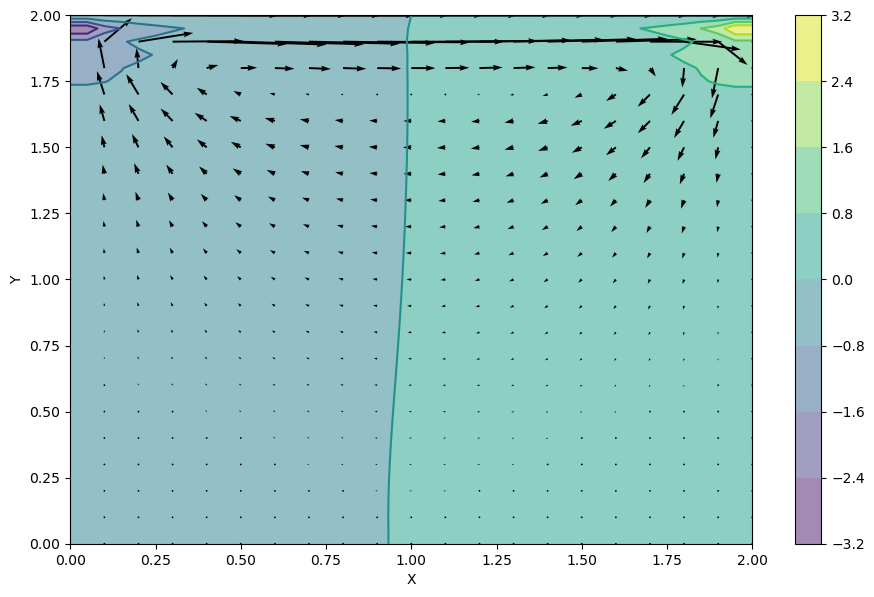

In [7]:
fig = pyplot.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
# 将压力场绘制成等高线
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
pyplot.colorbar()
# plotting the pressure field outlines
# 绘制压力场轮廓图
pyplot.contour(X, Y, p, cmap=cm.viridis)  
# plotting velocity field
# 绘制速度场
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
pyplot.xlabel('X')
pyplot.ylabel('Y');

> You can see that two distinct pressure zones are forming and that the spiral pattern expected from lid-driven cavity flow is beginning to form. Experiment with different values of `nt` to see how long the system takes to stabilize.

你可以看到，两个不同的压力区正在形成，并且预期的由盖子驱动的空腔流动的螺旋模式开始形成。用不同的 "nt "值进行实验，看看系统需要多长时间才能稳定下来。

In [8]:
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))
nt = 700
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

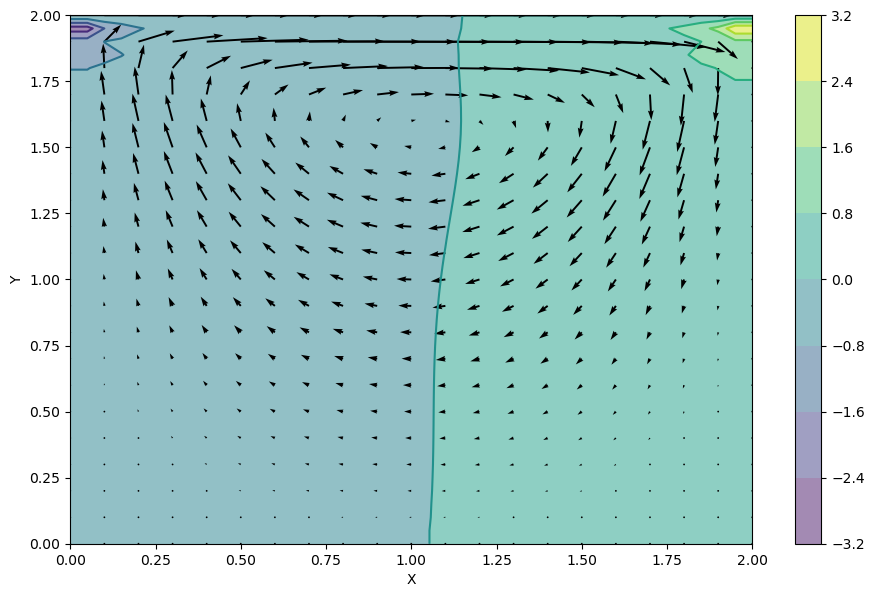

In [9]:
fig = pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');

> The quiver plot shows the magnitude of the velocity at the discrete points in the mesh grid we created. (We're actually only showing half of the points because otherwise it's a bit of a mess. The `X[::2, ::2]` syntax above is a convenient way to ask for every other point.)

曲线图显示了我们创建的网格中的离散点的速度大小。(我们实际上只显示了一半的点，否则就有点乱了。上面的 `X[::2, ::2]` 语法是一种方便的方法来询问其他每一个点）。

> Another way to visualize the flow in the cavity is to use a `streamplot`:

另一种可视化空腔内流动的方法是使用 `streamplot`：

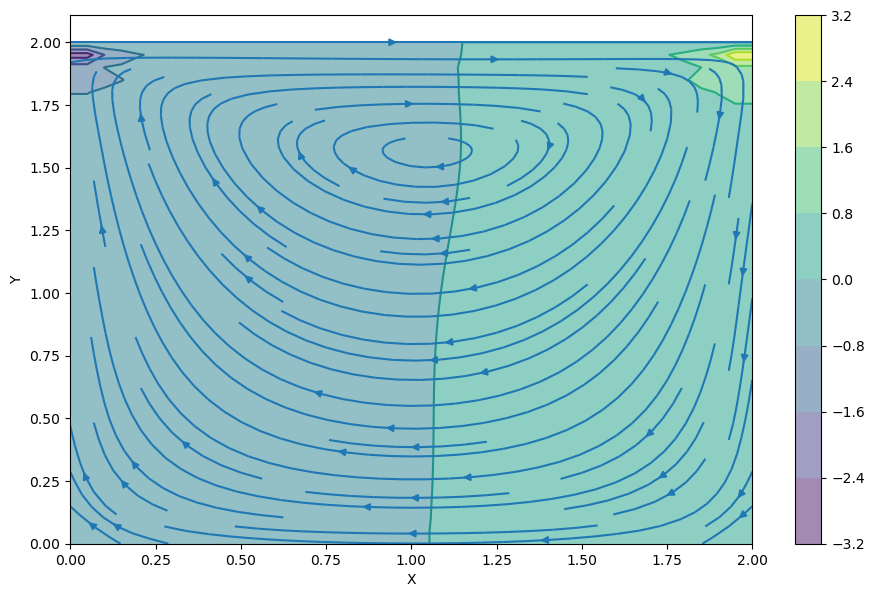

In [10]:
fig = pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.streamplot(X, Y, u, v)
pyplot.xlabel('X')
pyplot.ylabel('Y');